In this Notebook, we aim at creating some DataDriven surrogate models for the 1D Heat Equation in the divergence forme: 

$$
- \nabla \cdot \left(D(x)\, \nabla u\right) = 1
$$

the diffusion coefficient $D$ is no longer considered constant. Our goal here is to create params to solutions models mapping from $D$ to $u_D$.  

As we want to do it in a data driven manner, we first need a solver to generate data. To do so, we use the following finite difference scheme:

$$
- (\Delta x)^{-2}\left[D_{i-\frac12}\, u_{i-1} - (D_{i - \frac12} + D_{i +\frac12})\,u_i + D_{i + \frac12}\,u_{i + 1}\right] = 1
$$

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import torch
import copy

In [2]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family': 'serif', 'size' : 12})
rc('figure', **{'figsize' : (5, 3)})

In [3]:
sys.path.insert(1, '../..')

In [4]:
np.random.seed(seed=123)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Data Generation

First we need to generate data, to do so, we use the Solver module that will do everything for us in exchange for a dictionnary of params as input. 

There is some already recorded params in the config_step_3.py file 

In [6]:
from solvers.PoissonSolver import PoissonSolver
from config_step_3 import PARAMS_SOLVER

we consider in this work the terms of diffusion as Gaussian functions of center to be chosen in a uniform random matter:

In [7]:
def logn_fct(grid, num_fct, sigma=0.1, centers=None):
    D_logs = []

    if centers is None:
         centers = np.random.uniform(0.2, 0.8, num_fct)
        
    for c in centers:
        D_log = np.exp(-(grid - c)**2 / (2 * sigma**2)) + 1e-1
        D_logs.append(D_log)
    
    return np.stack(D_logs)

In [8]:
x = np.linspace(0., 1., 101)
D = logn_fct(x, 1, centers=[0.5])[0]
PARAMS_SOLVER['D'] = D

In [9]:
params_solver = copy.deepcopy(PARAMS_SOLVER)
solver = PoissonSolver(params=params_solver)

In [10]:
u = solver.solve

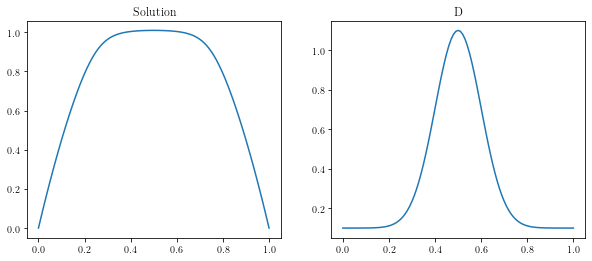

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(solver.x, u)
ax2.plot(solver.x, D)

ax1.set_title('Solution')
ax2.set_title('D')
plt.show()

In [12]:
VD = logn_fct(x, num_fct=100)

In [13]:
# Vectorized solver
VU = solver.Vsolve(vect = 'D', D = VD)

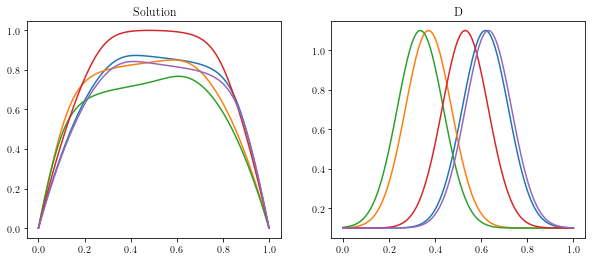

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
for sample in range(0, 5):
    ax1.plot(solver.x, VU[sample])
    ax2.plot(solver.x, VD[sample])
ax1.set_title('Solution')
ax2.set_title('D')
plt.show()

## DataDriven surrogate models creation

Now we want to create multiple surrogate models through different methods: POD, MLP, FNO and DeepONet

In practice, we just need to call DDMethod that will handle everything for us

In [15]:
from methods.DataDrivenMethods import DDMethod

In [16]:
# chose methods that you want to use
method_names = ['POD', 'MLP', 'DEEPONET', 'FNO'] 

Best model parameters and optimization hyperparameters for fitting each method have already been computed using optuna (see https://optuna.readthedocs.io/en/stable/index.html), we just need to import them (see optuna folder for more detail on the training)

In [17]:
from config_step_3 import PARAMS_METHODS, HYPERPARAMS_METHODS

In [18]:
PARAMS_METHODS['MLP']

{'method_name': 'MLP',
 'layer_dims': [2, 40, 33, 70, 89, 55, 118, 1],
 'activations': 'tanh',
 'device': device(type='cuda'),
 'seed': 123}

Create DDMethod object for each method

In [19]:
all_methods = {}
for method in method_names:
    params_method = copy.deepcopy(PARAMS_METHODS[method])
    params = {'solver': params_solver, 'method': params_method}
    all_methods[method] = DDMethod(params=params)

In [20]:
d_train, d_val, u_train, u_val = sklearn.model_selection.train_test_split(VD, VU, test_size=0.2, random_state=123)

In [21]:
nx = PARAMS_SOLVER['nx']
D_train = torch.Tensor(d_train).view(-1, 1)
D_val = torch.Tensor(d_val).view(-1, 1)

In [22]:
x = torch.Tensor(solver.x).view(-1, 1)
X_train = x.repeat(d_train.shape[0], 1)
X_val = x.repeat(d_val.shape[0], 1)

In [23]:
DX_train = torch.cat((D_train, X_train), dim=1)
DX_val = torch.cat((D_val, X_val), dim=1)
U_train = torch.Tensor(u_train).view(-1, 1)
U_val = torch.Tensor(u_val).view(-1, 1)

In [24]:
D_fno_train = torch.Tensor(d_train).unsqueeze(-1)
D_fno_val = torch.Tensor(d_val).unsqueeze(-1)

Load models for Neural Networks, and fit for methods

In [25]:
for method in method_names:
    hyperparams_method = copy.deepcopy(HYPERPARAMS_METHODS[method])
    
    if method == 'POD':
        all_methods[method].fit(hyperparameters=hyperparams_method, U=VU)
    
    elif method in ['MLP']:
         all_methods[method].fit(hyperparameters=hyperparams_method, 
                                 U_train=U_train, U_val=U_val, 
                                 DX_train=DX_train, DX_val=DX_val, 
                                 data_ratio=1., physics_ratio=0.)
        
    elif method == 'DEEPONET':
         all_methods[method].fit(hyperparameters=hyperparams_method, 
                                 U_train=u_train, U_val=u_val, 
                                 D_train=d_train, D_val=d_val)
    elif method == 'FNO':
        all_methods[method].fit(hyperparameters=hyperparams_method,
                                D_train=D_fno_train, D_val=D_fno_val, 
                                U_train=u_train, U_val=u_val)

Fitting POD
POD fitted
Fitting MLP


[tr : 7.0e-03, val : 8.7e-03]: 100%|█████| 20000/20000 [00:52<00:00, 378.28it/s]


MLP fitted
Fitting DEEPONET


[tr : 8.0e-05, val : 6.9e-05]: 100%|█████| 20000/20000 [00:53<00:00, 373.57it/s]


DEEPONET fitted
Fitting FNO


[tr : 3.2e-08, val : 4.1e-08]: 100%|█████| 20000/20000 [01:51<00:00, 178.87it/s]

FNO fitted


MLP 21849
DEEPONET 2384129
FNO 105632


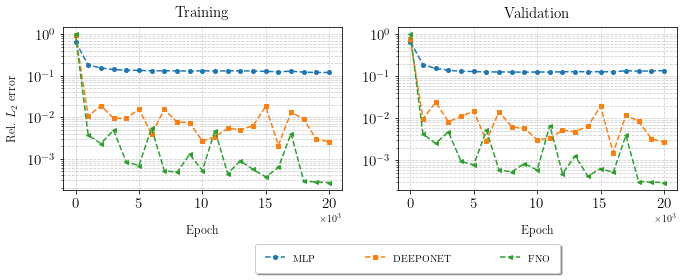

In [28]:
fig, axs = plt.subplots(1, 2, figsize = (11, 3))

for mark, method in zip(['--o', '--s', '--<'], ['MLP', 'DEEPONET', 'FNO']):
    
    l2_err_train = all_methods[method]._method._l2_losses['train']
    l2_err_val = all_methods[method]._method._l2_losses['val']
    
    num_parameters = all_methods[method]._method.num_parameters()
    print(method, num_parameters)
    
    axs[0].plot(range(0, 20000, 999), l2_err_train[::999], mark, markersize=4, label = method)
    axs[1].plot(range(0, 20000, 999), l2_err_val[::999], mark, markersize=4, label = method)

axs[0].set_ylabel('Rel. $L_2$ error', size=12, labelpad = 10)
axs[0].set_title('Training', size = 15, pad = 10)
axs[1].set_title('Validation', size = 15, pad = 10)

for i in range(2):
    
    axs[i].grid(True, which='both', alpha = .6, ls='dashed')
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Epoch', fontsize = 12, labelpad=15)
    
    axs[i].tick_params(axis='both', which='major', labelsize=15)
    # axs[i].set_xlim(-500, 10500)
    axs[i].ticklabel_format(style='sci', axis='x', scilimits=(3, 3))

axs[0].legend(bbox_to_anchor=(1.8, -0.3), ncol=3, columnspacing = 5, shadow = True, borderpad = 1)
plt.savefig('l2_step_3.pdf', bbox_inches = 'tight')
plt.show()

# Plot performances for each method

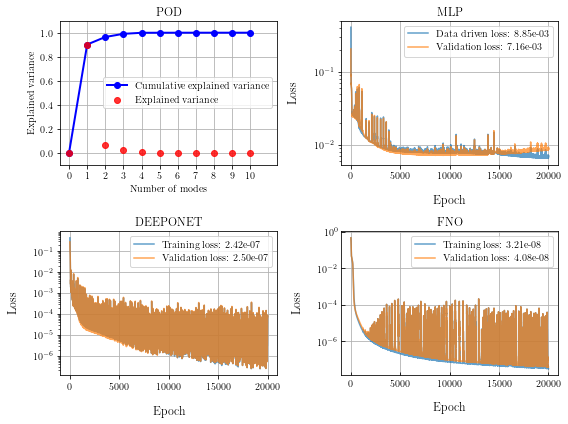

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6)) 

for i, (ax, method) in enumerate(zip(axs.flatten(), all_methods)):
    all_methods[method].plot(ax)
    ax.title.set_text(method)
    
fig.tight_layout()
plt.show()

## In/Out distribution analysis

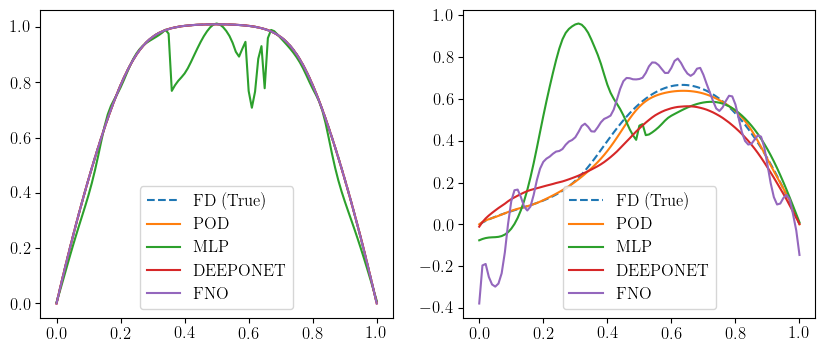

In [28]:
new_D = logn_fct(solver.x, 1, centers=[0.5])[0]
solver.change_D(D=new_D)
U_FD = solver.solve

fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize= (10, 4))
ax_0.plot(solver.x, U_FD, '--', label=f'FD (True)')

for method in all_methods:
    U_pred = all_methods[method].apply_method(phi = new_D, D = new_D).flatten()
    ax_0.plot(solver.x, U_pred, label=f'{method}')
    
# ax_0.title.set_text(f'$a$ = {new_a}')
ax_0.legend()

OOD_D = logn_fct(solver.x, 1, centers=[0.1])[0]
solver.change_D(D=OOD_D)
U_OOD = solver.solve

ax_1.plot(solver.x, U_OOD, '--', label=f'FD (True)')

for method in all_methods:
    U_pred = all_methods[method].apply_method(phi = OOD_D, D = OOD_D).flatten()
    ax_1.plot(solver.x, U_pred, label=f'{method}')
    
# ax_1.title.set_text(f'$a$ = {OOD_a}')
ax_1.legend()
plt.show()

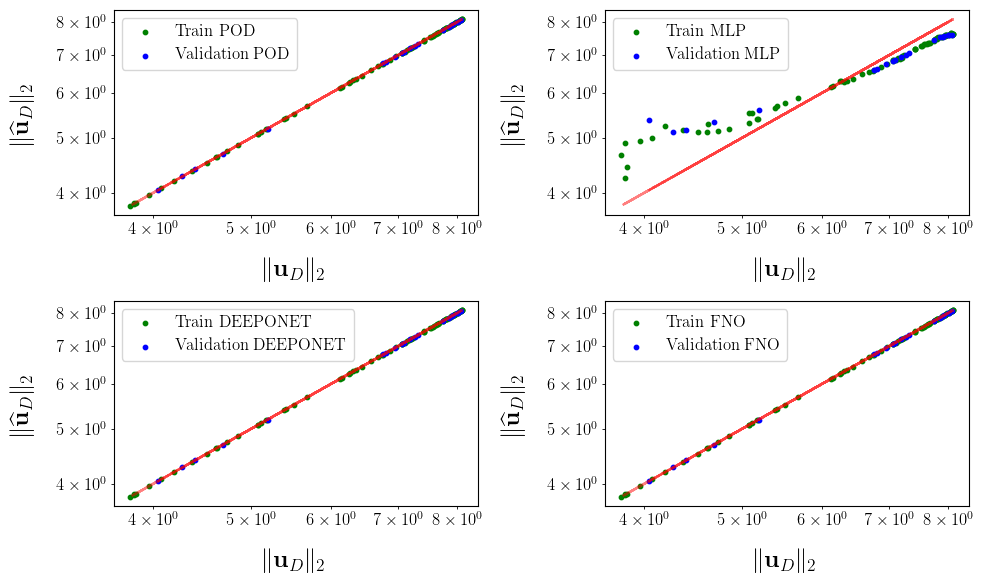

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

for i, (ax, method) in enumerate(zip(axs.flatten(), all_methods)):
    all_methods[method].parity_plot(U=u_train, phi=d_train, D=d_train, ax=ax, label=f'Train {method}', color='green')
    all_methods[method].parity_plot(U=u_val, phi=d_val, D=d_val, ax=ax, label=f'Validation {method}', color='blue')
    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')
    
plt.tight_layout()
plt.show()

In [30]:
#### OUT OF DISTRIBUTION D GENERATION ######
OOD_centers = np.concatenate([np.linspace(0.1, 0.2, 21), np.linspace(0.8, 0.9, 21)])
OOD_VD = logn_fct(solver.x, 1, centers=OOD_centers)
OOD_VU = solver.Vsolve(vect = 'D', D = OOD_VD)
                
OOD_VD = torch.Tensor(OOD_VD)
OOD_VU = torch.Tensor(OOD_VU)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

for i, (ax, method) in enumerate(zip(axs.flatten(), all_methods)):
    all_methods[method].parity_plot(U=VU, phi = VD, D=VD, ax=ax, label=f'ID {method}', color='green')
    all_methods[method].parity_plot(U=OOD_VU, phi= OOD_VD, D=OOD_VD, ax=ax, label=f'OOD {method}', color='blue')
    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')
    
plt.tight_layout()
plt.show()